In [10]:
import networkx as nx
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [1]:
from skyfield.api import load, wgs84

stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
satellites = load.tle_file(stations_url)
print('Loaded', len(satellites), 'satellites')
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['STARLINK-1007']

# year, month, day, hour, minute, second
ts=load.timescale()
t = ts.now()
a=satellite.at(t)
lat, lon = wgs84.latlon_of(a)
print('Latitude:', lat)
print('Longitude:', lon)

Loaded 4219 satellites
Latitude: -51deg 46' 25.1"
Longitude: -112deg 21' 05.7"


In [2]:
from common import calculate_visible_satellites

# garching coordinates
observer_latitude = 48.2489
observer_longitude = 11.6532
observer_elevation = 0

visible_satellites = calculate_visible_satellites(
    observer_latitude, observer_longitude, observer_elevation, distance_km=800
)

for sat, alt, az in visible_satellites:
    print(sat.name)
    # print(f"Satellite: {sat}")
    # print(f"Altitude: {alt.degrees} degrees")
    # print(f"Azimuth: {az.degrees} degrees")

STARLINK-3862
STARLINK-4494
STARLINK-4508
STARLINK-5611
STARLINK-5603
STARLINK-5499
STARLINK-5595
STARLINK-5599
STARLINK-5606
STARLINK-5583
STARLINK-5584
STARLINK-5557
STARLINK-5591
STARLINK-5835
STARLINK-5833
STARLINK-5812
STARLINK-5809
STARLINK-5817


In [4]:
def idplot(base,hops,_type,method, host=None):
    G = nx.Graph()
    g = {}
    for file in os.listdir(base):
        filename = os.fsdecode(file)
        if _type in filename and method in filename:
            with open(base + filename, "r") as csvfile:
                d = list(csv.reader(csvfile))
                for r in range(len(d)-(30-hops)):
                    ip1 = d[r][2]
                    ip2 = d[r + 1][2]
                    effe = ["*", "ip"]
                    if ip1 not in effe and ip2 not in effe:
                        if ip1 not in g:
                            g[ip1] = []
                        if ip2 not in g[ip1]:
                            g[ip1].append(ip2)

    for k, v in g.items():
        G.add_node(k)
        for i in v:
            G.add_edge(k, i)

    return G

def draw(G):
    _,degree = map(list, zip(*G.degree())) 
    nx.draw_kamada_kawai(
            G,
            node_color=range(len(G.degree())),
            cmap=plt.cm.GnBu,
            # node_size=[(v * 500) + 1 for v in  degree],
            # with_labels=True,
        )

In [5]:
def cloud_draw(provider,hops,method):
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 2, 1)   # Define 3 rows, 2 column, Activate subplot 1. 
    base = f"/home/rc/idp-castellotti-data/new-traceroutes/{provider}/"
    plt.subplot(321).set_title(f"{provider} starlink {hops} hops {method}")
    G=idplot(base=base,hops=8,_type="starlink",method=method)
    draw(G)
    plt.subplot(322).set_title(f"{provider} normal {hops} hops {method} ")
    G=idplot(base=base,hops=hops,_type="normal",method=method)
    draw(G)
    plt.show()

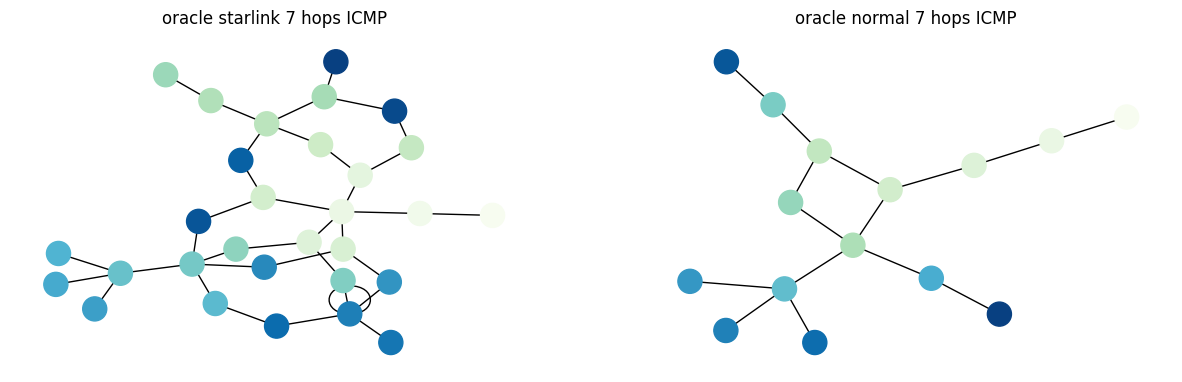

In [6]:
cloud_draw(provider="oracle",hops=7,method="ICMP")

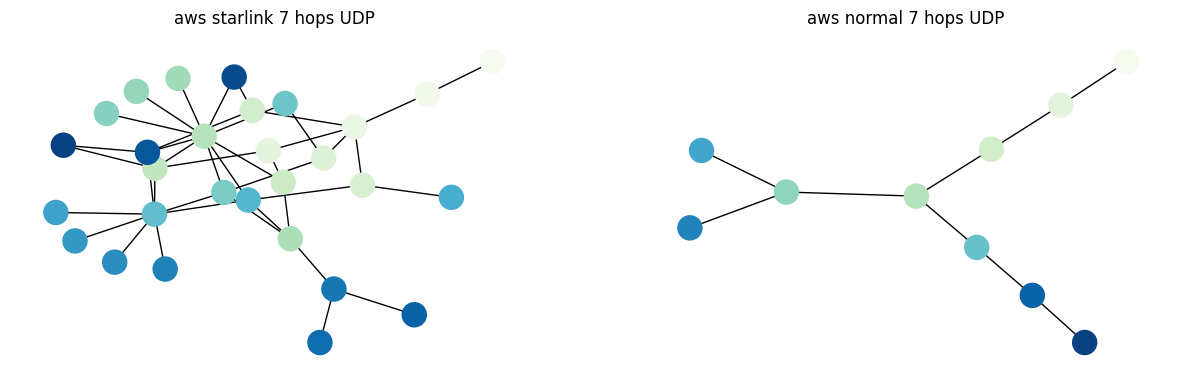

In [7]:
cloud_draw(provider="aws",hops=7,method="UDP")

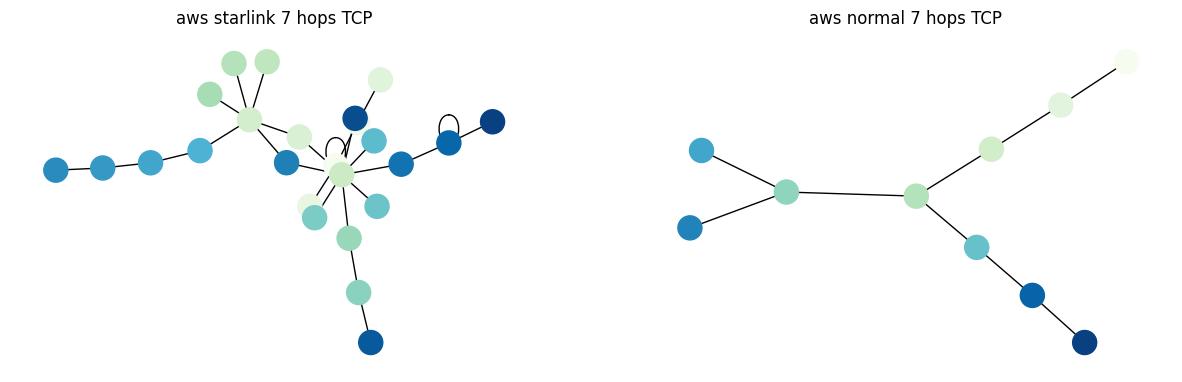

In [8]:
cloud_draw(provider="aws",hops=7,method="TCP")

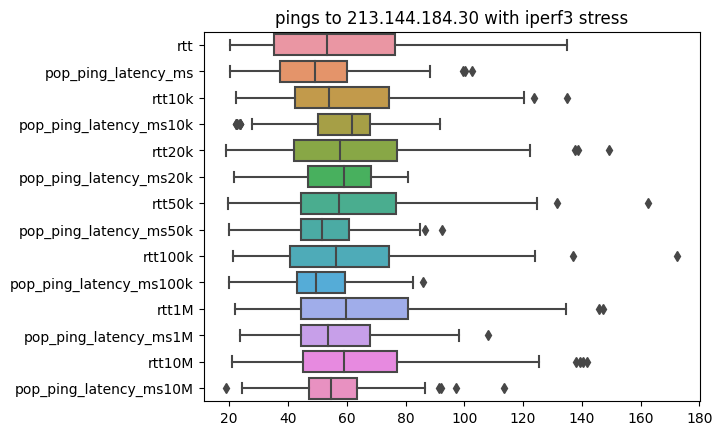

In [15]:
df0 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-normal.csv")
df1 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-10k.csv")
df2 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-20k.csv")
df3 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-50k.csv")
df4 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-100k.csv")
df5 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-1M.csv")
df6 = pd.read_csv("/home/rc/idp-castellotti-data/ping-bw-10M.csv")
df = pd.concat([df0, df1, df2, df3, df4, df5, df6], axis=1).reindex(df1.index)
sns.boxplot(
    data=df[
        [
            "rtt",
            "pop_ping_latency_ms",
            "rtt10k",
            "pop_ping_latency_ms10k",
            "rtt20k",
            "pop_ping_latency_ms20k",
            "rtt50k",
            "pop_ping_latency_ms50k",
            "rtt100k",
            "pop_ping_latency_ms100k",
            "rtt1M",
            "pop_ping_latency_ms1M",
            "rtt10M",
            "pop_ping_latency_ms10M",
        ]
    ],
    orient="h",
).set_title("pings to 213.144.184.30 with iperf3 stress")
plt.show()

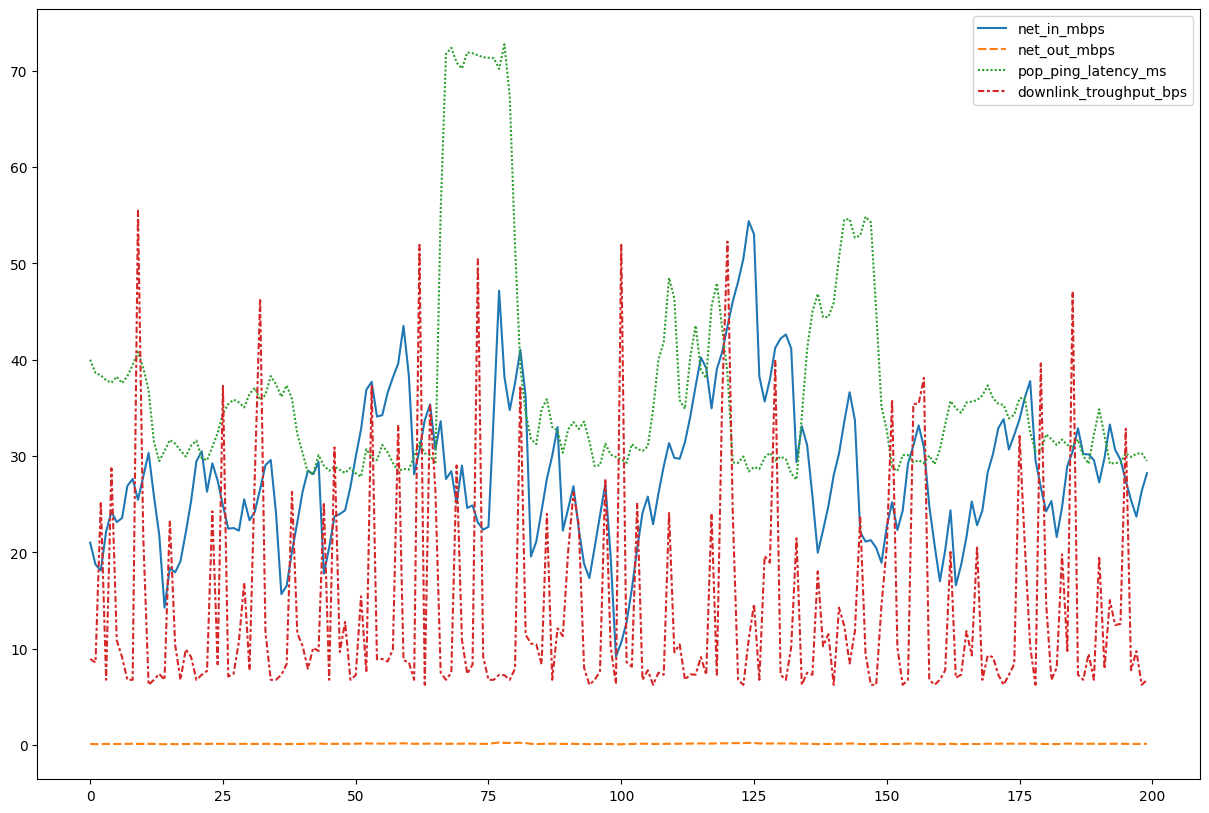

In [14]:
plt.figure(figsize=(15, 10))
df = pd.read_csv('/home/rc/idp-castellotti-data/large_file_download.csv').head(200)
df['timestamp'] = pd.to_datetime(df['timestamp'], format ='%Y-%m-%d %H:%M:%S.%f')
sns.lineplot(data=df,dashes=True)
plt.show()

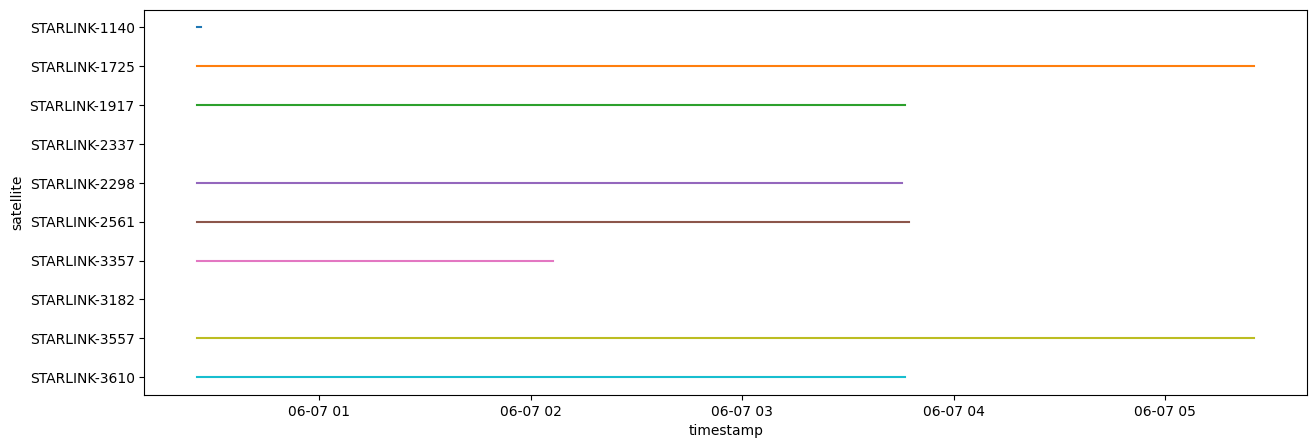

In [13]:
plt.figure(figsize=(15, 5))
df = pd.read_csv('/home/rc/idp-castellotti-data/visible_satellites.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format ='%Y-%m-%d %H:%M:%S.%f')

unique_satellites=df['satellite'].unique()[:10]
count=0
for sat in unique_satellites:
    daf=df.loc[df['satellite'] == sat][["timestamp","satellite","pop_ping_latency_ms"]]
    sns.lineplot(data=daf, x="timestamp", y="satellite",dashes=True)
    count+=1

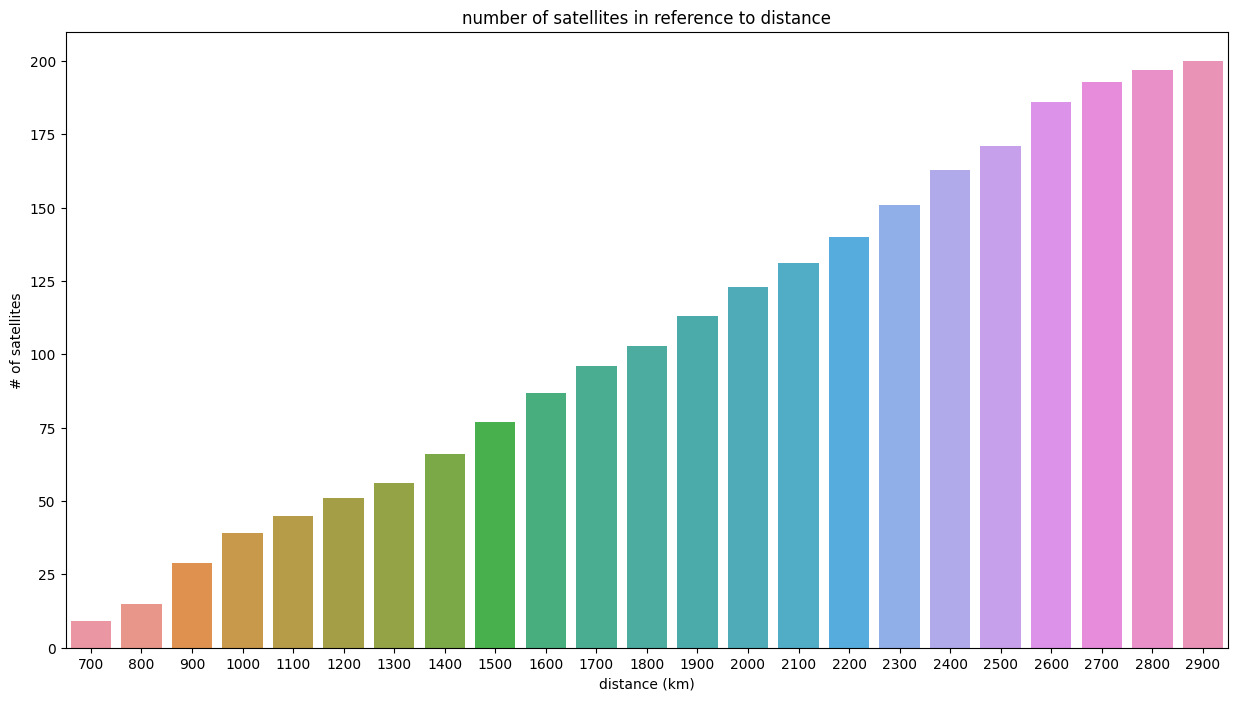

In [12]:
df = pd.read_csv('/home/rc/idp-castellotti-data/visible_satellites_variable_distance.csv')
plt.figure(figsize=(15, 8))
sns.countplot(x=df["distance"]).set_title("number of satellites")
plt.ylabel("# of satellites")
plt.xlabel("distance (km)")
plt.show()